# Работа с базами данных (2)

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Макрушин С.В. Лекция "Работа с базами данных"
* https://sqliteonline.com/
* https://docs.python.org/3/library/sqlite3.html
* https://www.sqlitetutorial.net/sqlite-index/
* https://docs.python.org/3/library/sqlite3.html#sqlite3.IntegrityError
* https://www.sqlitetutorial.net/sqlite-alter-table/
* https://www.sqlitetutorial.net/sqlite-create-view/
* https://habr.com/ru/post/664000/
* https://learnsql.com/blog/what-is-common-table-expression/


In [1]:
import pandas as pd
import csv
import sqlite3

## Задачи для совместного разбора

1\. Добавить столбец Age со значением по умолчанию. Добавить запись к таблицу

2\. Занумеруйте студентов в рамках каждой группы.

3\. Выведите уникальные номера студентов

## Лабораторная работа 4

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy` и `pandas`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy` или структур `pandas` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

__Для начала работы подключитесь к БД `recipes.db` и создайте объект-курсор.__

<p class="task" id="1"></p>

1\. Создайте уникальный индекс для таблицы `Review` для обеспечения уникальности сочетания значений в полях `user_id` и `recipe_id`. 

In [2]:
con = sqlite3.connect("sqlite3")

In [3]:
cur = con.cursor()

In [4]:
cur.execute('CREATE UNIQUE INDEX new_index ON Review (user_id, recipe_id)')

<p class="task" id="2"></p>

2\. Напишите функцию `add_review(review_id, user_id, recipe_id, date, rating, review)`, которая добавляет запись в таблицу `Review`. В случае успешного добавления функция должна вернуть значение 0. В случае нарушения ограничения целостности функция должна вернуть значение 1. В случае любых других ошибок функция должна вернуть значение 2. Продемонстрируйте работу функции, попытавшись добавить одну и ту же запись дважды в двух ячейках подряд.

Для решения задачи воспользуйтесь механизмом try - except и обработайте соответствующее исключение.

In [5]:
def add_review(review_id, user_id, recipe_id, date, rating, review):
    try:

        conn = sqlite3.connect('sqlite3')
        cur = conn.cursor()


        cur.execute("INSERT INTO Review (id, user_id, recipe_id, date, rating, review) VALUES (?, ?, ?, ?, ?, ?)",
                    (review_id, user_id, recipe_id, date, rating, review)) ## Добавление записи в таблицу Review

        
        conn.commit()


        return 0
    except sqlite3.IntegrityError:
        return 1  # Обработка ошибки нарушения ограничения целостности
    except:
        return 2

In [6]:
add_review(1,1,1,'2022-08-12',5, 'SO BAD, Really is ...')

0

In [7]:
add_review(1,1,1,'2022-08-12',5, 'SO BAD, Really is ...')

1

In [8]:
a=cur.execute("SELECT * FROM Review WHERE id = 1 ")
a

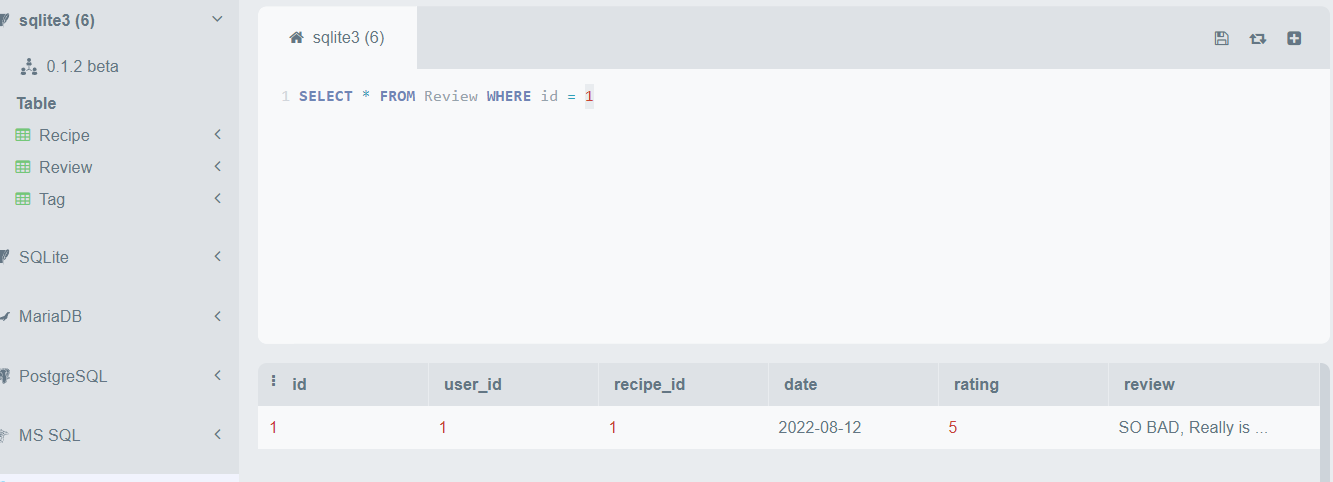

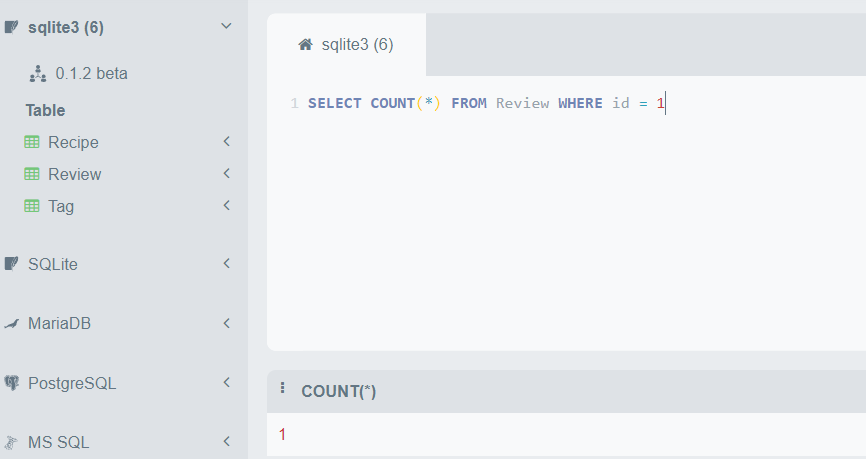

<p class="task" id="3"></p>

3\. _Измените_ таблицу Review, добавив в нее поле `toxic` булева типа. 

In [10]:
sql='''
ALTER TABLE Review
    ADD COLUMN toxic BOOLEAN
'''
cur.execute(sql)
con.commit()
pd.read_sql_query('Select * FROM Review', con)

,id,user_id,recipe_id,date,rating,review,toxic
0,370476,21752,57993,2003-05-01,5,Last week whole sides of frozen salmon fillet ...,None
1,624300,431813,142201,2007-09-16,5,So simple and so tasty! I used a yellow capsi...,None
2,187037,400708,252013,2008-01-10,4,"Very nice breakfast HH, easy to make and yummy...",None
3,706134,2001852463,404716,2017-12-11,5,These are a favorite for the holidays and so e...,None
4,312179,95810,129396,2008-03-14,5,Excellent soup! The tomato flavor is just gre...,None
...,...,...,...,...,...,...,...
126692,158736,2282344,8701,2012-06-03,0,This recipe is outstanding. I followed the rec...,None
126693,1059834,689540,222001,2008-04-08,5,"Well, we were not a crowd but it was a fabulou...",None
126694,453285,2000242659,354979,2015-06-02,5,I have been a steak eater and dedicated BBQ gr...,None
126695,691207,463435,415599,2010-09-30,5,Wonderful and simple to prepare seasoning blen...,None


<p class="task" id="4"></p>

4\. Вам дан классификатор `clf`, который классифицирует тексты отзывов как токсичные (`True`) и не токсичные (`False`).
Напишите функцию `classify_reviews`, которая итеративно получает пакет (батч) `batch_size` строк из таблицы Reviews, у которых не проставлено значение в столбце `toxic`, делает для них прогноз при помощи модели `clf` и обновляет соответствующие строки в БД. Данная процедура выполняется до тех пор, пока в БД есть строки, для которых требуется получить прогноз.

Продемонстрируйте результат, выведя на экран количество токсичных и не токсичных отзывов в таблице.

In [11]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy="uniform").fit(None, [True, False])

def classify_reviews(batch_size, con):
    cur = con.cursor()
    
    # Получаем первый пакет отзывов
    cur.execute(f'SELECT * FROM Review WHERE toxic IS NULL LIMIT {batch_size}') #запрос на выборку строк из таблицы Review, количество batch_size 
    rows = cur.fetchall() #получаем все выбранные строки, спис корт
    
    while rows:
        ids = [row[0] for row in rows] #создание списка, содержащий значения из первого столбца каждой строки rows.
        reviews = [row[5] for row in rows] #создание списка, содержащий значения из шестого столбца каждой строки rows.
        
        predictions = clf.predict(reviews) #делает прогноз токсичности каждого отзыва 
        cur.executemany('UPDATE Review SET toxic = ? WHERE id = ?', zip(predictions, ids))
        con.commit()
        
        cur.execute(f'SELECT * FROM Review WHERE toxic IS NULL LIMIT {batch_size}')
        rows = cur.fetchall() #сохраняет результат выполнения запроса в rows
    
    
    return pd.read_sql_query('SELECT * FROM Review', con)

Заметка себе: zip создает иттератор , который объединяет элементы двух списков. поочередно выдает кортежи, содержащие прогнозы и соответсвующие им айдишникик. f-префикс для строк форматирования

In [13]:
classify_reviews(150, con)

,id,user_id,recipe_id,date,rating,review,toxic
0,370476,21752,57993,2003-05-01,5,Last week whole sides of frozen salmon fillet ...,b'\x01'
1,624300,431813,142201,2007-09-16,5,So simple and so tasty! I used a yellow capsi...,b'\x00'
2,187037,400708,252013,2008-01-10,4,"Very nice breakfast HH, easy to make and yummy...",b'\x01'
3,706134,2001852463,404716,2017-12-11,5,These are a favorite for the holidays and so e...,b'\x00'
4,312179,95810,129396,2008-03-14,5,Excellent soup! The tomato flavor is just gre...,b'\x00'
...,...,...,...,...,...,...,...
126692,158736,2282344,8701,2012-06-03,0,This recipe is outstanding. I followed the rec...,b'\x00'
126693,1059834,689540,222001,2008-04-08,5,"Well, we were not a crowd but it was a fabulou...",b'\x00'
126694,453285,2000242659,354979,2015-06-02,5,I have been a steak eater and dedicated BBQ gr...,b'\x01'
126695,691207,463435,415599,2010-09-30,5,Wonderful and simple to prepare seasoning blen...,b'\x00'


In [14]:
con.commit()

In [15]:
cur.execute("""
    UPDATE Review
    SET toxic = CASE toxic
        WHEN x'01' THEN ?
        WHEN x'00' THEN ?
        ELSE toxic
    END
""", (True, False))
#set-обновить case-позволяет нам выполнять условные операции

In [16]:
cur.execute("SELECT toxic, COUNT(*) FROM Review GROUP BY toxic;")
rows = cur.fetchall()
for row in rows:
    toxic = bool(row[0])
    count = row[1]
    print(f'Toxic: {toxic}, Count: {count}')

Toxic: False, Count: 63210
Toxic: True, Count: 63487


<p class="task" id="5"></p>

5\. Создайте представление `RecipeWithYear`, в котором добавлен дополнительный столбец `year`, содержащий год даты из столбца `submitted`. Сделайте выборку из этого представления и выведите на экран количество рецептов с разбивкой по годам.

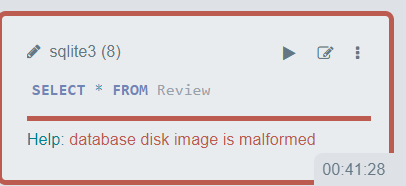

***Не знаю почему, но после 4 номера файл с БД ломается, он перестает обрабатывать запросы и из-за этого не работает 5 номер***

In [5]:
sql=('''CREATE VIEW RecipeWithYear AS
SELECT *, strftime('%Y', submitted) AS year
FROM Recipe;
''')

In [6]:
cur.execute('''CREATE VIEW RecipeWithYear AS
SELECT *, strftime('%Y', submitted) AS year
FROM Recipe;
''')

 2)выбираются все столбцы таблицы Recipe, а также создается новый столбец year, содержащий год ('%Y') из столбца submitted

In [7]:
cur.execute("SELECT year, COUNT(*) AS count FROM RecipeWithYear GROUP BY year;") 
#запрос на выборку количества рецептов, сгруппированных по годам.

In [8]:
pd.read_sql_query('SELECT year, COUNT(*) AS count FROM RecipeWithYear GROUP BY year;', con)

,year,count
0,1999,275
1,2000,104
2,2001,589
3,2002,2644
4,2003,2334
5,2004,2153
6,2005,3130
7,2006,3473
8,2007,4429
9,2008,4029


<p class="task" id="6"></p>

6\. Напишите запрос на языке SQL, который возвращает все строки из таблицы `Recipe` с дополнительным столбцом, содержащем номер рецепта. Рецепты нумеруются целыми числами, начиная с 1, в __рамках каждого года__ в порядке их добавления в БД (столбец `submitted`). Получите результат в виде `pd.DataFrame`. Посчитайте и выведите на экран количество строк полученного `pd.DataFrame`, для которых сгенерированный номер кратен 50.

row_number() нумерует строки в каждой группе, созданной разбиением (partition) таблицы Recipe на группы по году 

In [15]:
sql="SELECT *,row_number() OVER (partition by strftime('%Y',submitted)) AS nuber from Recipe"
data=pd.read_sql_query(sql,con)
data

,id,name,minutes,submitted,description,n_ingredients,nuber
0,3441,30 minute smoked sausage and corn chowder,30,1999-10-18,"i love corn chowder, have a pot on now! recipe...",8.0,1
1,4205,alfredo fettuccine,25,1999-11-09,recipe from the olive garden cookbook,5.0,2
2,3258,alfredo sauce with pasta,0,1999-10-10,None,6.0,3
3,153,amish friendship bread and starter,70,1999-09-06,many recipes have been posted for the amish br...,12.0,4
4,5197,anytime cheese ball,0,1999-12-15,None,5.0,5
...,...,...,...,...,...,...,...
29995,535269,sweet tea baby back ribs,1560,2018-03-05,"courtesy of deborah van treece, twisted soul",14.0,20
29996,535555,the best ground beef tacos on the planet,55,2018-04-09,"ok, i might be a bit over confident in the tit...",13.0,21
29997,535389,vietnamese chicken,50,2018-03-20,vietnamese chicken with ginger.,11.0,22
29998,534786,white bean and chicken chili,50,2018-01-02,most recipes for white bean and chicken chilie...,11.0,23


In [16]:
data[data['nuber']%50 == 0]

,id,name,minutes,submitted,description,n_ingredients,nuber
49,3803,cheese straws with rice krispies,55,1999-11-10,yum,NaN,50
99,1662,diabetic carrot raisin salad,125,1999-09-30,None,4.0,100
149,4135,jack daniel s marinade,60,1999-11-07,i guess you could just add cooked shrimp after...,8.0,150
199,2804,peach sour cream pie,0,1999-08-21,None,8.0,200
249,4706,takefumi rice,18,1999-12-01,None,NaN,250
...,...,...,...,...,...,...,...
29591,494403,peppered herb flank steak,35,2013-01-29,this is adapted from a recipe in simply classi...,NaN,350
29641,497588,scalloped potatoes and ham pioneer woman,80,2013-03-14,once again ree drummond hits it out of the bal...,11.0,400
29691,500022,taiwanese walnut cookies,55,2013-05-08,taiwanese walnut cookies are very nutty and ri...,7.0,450
29781,513160,easy cherry pie bars,50,2014-02-09,from the budget101.com website...\r\n\r\nmy fa...,10.0,50


<p class="task" id="7"></p>

7\. Используя обобщенное табличное выражение и решение задачи 6, напишите запрос на языке SQL, который вернет количество строк, для которых сгенерированный номер кратен 50. Выполните запрос и выведите количество таких строк на экран.

In [26]:
sql='''
WITH zapros AS
    (SELECT *,row_number() OVER (partition by strftime('%Y',submitted)) AS nuber from Recipe)

SELECT COUNT(*)
FROM zapros
WHERE nuber %50=0
'''

In [27]:
pd.read_sql_query(sql,con)

,COUNT(*)
0,589
